# Demostration of ICAROS

## The purpose of this NB is: 

- Selecting events.

- Checking run conditions are normal.

- Computing XY correction maps.


## It is divided into three main sections:

1. __Section A:__ Map building with the automatic script that will be run by the shifter in Canfranc.

2. __Section B:__ Dissection of the script, function by function, to show the performance of each one.

2. __Section C:__ In case the map is produced, map checking.

In [1]:
import os
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [2]:
run_number = 8619 # 8070 # for testing
num_files = 312 # -1 # for testing
analysis_tag = 'st200819' # st200819 # for testing

In [3]:
folder_dst       = '/Volumes/NEXT_data/IC_Data/kdst/'+str(run_number)+'/'
dst_file       = '*.h5'
config_file    = '$ICARO/krcal/map_builder/config_NoChecks.conf'
ref_histo_file = '$ICARO/krcal/map_builder/reference_files/z_dst_LB_mean_ref.h5'

In [4]:
summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+'_'+analysis_tag+"/"

In [5]:
import subprocess

bash_mkdir = "mkdir " + summary_outputs
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()
print(bash_mkdir)

bash_mkdir = "mkdir " + summary_outputs + '/plots/'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()
print(bash_mkdir)

mkdir /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/
mkdir /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819//plots/


In [6]:
vals_dir_loc = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run_number)+analysis_tag+'/'
bash_mkdir = "mkdir " + vals_dir_loc
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [7]:
vals_loc = vals_dir_loc + 'vals_'+str(run_number)+'.txt'
bash_touch = "touch " + vals_loc
process = subprocess.Popen(bash_touch, stdout=subprocess.PIPE, shell=True).wait()
print(bash_touch)

touch /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_8070st200819/vals_8070.txt


In [8]:
summary_vals = open(vals_loc, 'w')
summary_vals.write('runNumber='+str(run_number)+'\n')
summary_vals.write('numFiles='+str(num_files)+'\n')
summary_vals.close()

*Set input/output variables and configuration file*

In [9]:
from invisible_cities.core.configure         import configure

output_maps_file = '/Volumes/NEXT_data/IC_Data/'+analysis_tag+'/maps/'

file_bootstrap   = '/Users/jmhaefner/Documents/NEXT_code/IC_current/IC_test/IC/invisible_cities/database/test_data/kr_emap_xy_100_100_r_6573_time.h5'

map_file_out     = os.path.join(output_maps_file, 'kr_emap_xy_r_'+str(run_number)+'_'+analysis_tag+'.h5')
histo_file_out   = os.path.join(output_maps_file, 'kr_hist_xy_r_'+str(run_number)+'_'+analysis_tag+'.h5')

print('Input dst: ', folder_dst + dst_file)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

ref_Z_histogram = dict(
                    ref_histo_file = ref_histo_file,
                    key_Z_histo    = 'histo_Z_dst') 

config = configure(f'maps {config_file}'.split())

config.update(dict(folder             = folder_dst     ,
                   file_in            = dst_file       ,
                   file_out_map       = map_file_out   ,
                   file_out_hists     = histo_file_out ,
                   ref_Z_histogram    = ref_Z_histogram,
                   run_number         = run_number     ,
                   file_bootstrap_map = file_bootstrap))

Input dst:  /Volumes/NEXT_data/IC_Data/kdst/8070/*.h5
Output map file:  /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/maps_new/MAP_TESTTEST.h5
Output histograms file:  /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/maps_new/MAP_TESTTEST.h5


***

#### Imports

In [10]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import check_rate_and_hist
from krcal.map_builder.map_builder_functions  import selection_nS_mask_and_checking
from krcal.core.kr_types                      import type_of_signal
from krcal.map_builder.map_builder_functions  import check_Z_dst
from krcal.map_builder.map_builder_functions  import band_selector_and_check
from krcal.map_builder.map_builder_functions  import get_binning_auto
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.selection_functions           import selection_in_band

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections        import read_maps
from krcal.map_builder.map_builder_functions  import e0_xy_correction

from krcal.core.io_functions                  import write_complete_maps
from krcal.core.selection_functions           import get_time_series_df

from krcal.NB_utils   .xy_maps_functions     import draw_xy_maps
from krcal.core       .map_functions         import relative_errors
from krcal.core       .map_functions         import add_mapinfo

from invisible_cities.reco.corrections       import apply_all_correction

from krcal.NB_utils.plt_functions                import plot_s1histos
from krcal.NB_utils.plt_functions                import s1d_from_dst
from krcal.NB_utils.plt_functions                import plot_s2histos
from krcal.NB_utils.plt_functions                import s2d_from_dst
from krcal.NB_utils.plt_functions                import plot_selection_in_band

from krcal.core.core_functions                import time_delta_from_time
from krcal.core.fitmap_functions              import time_fcs_df
from krcal.NB_utils.plt_functions             import plot_time_fcs

from invisible_cities.core.configure          import configure

#### Loading data (only events inside detector chamber; i.e. R<=492)

In [11]:
config_values  = config.as_namespace
quality_ranges = config_values.quality_ranges
quality_ranges['r_max'] = 200
print(' Only events with R smaller than {}'.format(quality_ranges['r_max']))
inputs = load_data(input_path         = folder_dst                       ,
                   input_dsts         = dst_file                         ,
                   file_bootstrap_map = file_bootstrap                   ,
                   ref_histo_file     = ref_Z_histogram['ref_histo_file'],
                   key_Z_histo        = ref_Z_histogram['key_Z_histo']   ,
                   quality_ranges     = quality_ranges                   )

dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]

 Only events with R smaller than 200


In [12]:
totalNumS2  = np.sum(dst[~dst.event.duplicated()].nS2)
totalNumEvt = dst.event.nunique()
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'totalNumS2={totalNumS2}\n')
summary_vals.write(f'totalNumEvt={totalNumEvt}\n')
summary_vals.close()

print('nEvt, nS2 =', totalNumEvt, ',', totalNumS2)

nEvt, nS2 = 720338 , 730833


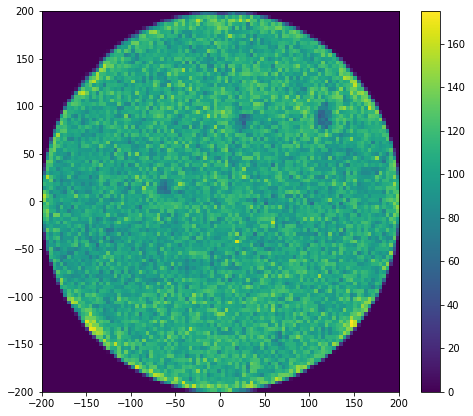

In [13]:
plt.figure(figsize=(8, 7))
plt.hist2d(dst.X, dst.Y, 100);
plt.colorbar();

### 1st check: rate before selection

## Event selection

### nS1 selection (2nd check)

In [14]:
#nS1_eff_interval = (config_values.nS1_eff_min, config_values.nS1_eff_max)
#with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
#    mask_s1 = selection_nS_mask_and_checking(dst        = dst               ,
#                                             column     = type_of_signal.nS1,
#                                             interval   = nS1_eff_interval  ,
#                                             output_f   = store_hist        ,
#                                             input_mask = None              ,
#                                             nbins_hist = 10                ,
#                                             range_hist = (0,10)            ,
#                                             norm       = True              )

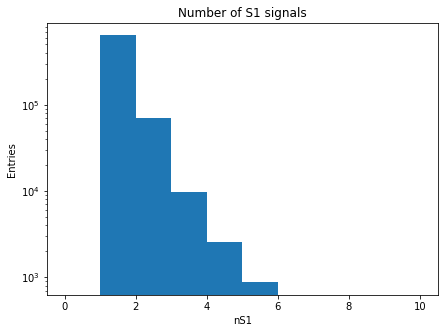

In [15]:
plt.figure(figsize=(7,5));
plt.hist(dst.drop_duplicates(subset='event').nS1, 10, (0, 10))
plt.yscale('log');
plt.xlabel('nS1');
plt.ylabel('Entries');
plt.title('Number of S1 signals');

In [16]:
mask_s1 = dst.nS1==1

In [17]:
eff = dst[mask_s1].event.nunique()/dst.event.nunique()
print('S1 selection efficiency: ', eff*100, '%')
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'fracS1={round(eff,2)}\n')
summary_vals.close()

S1 selection efficiency:  88.53718670957245 %


*Some other S1 plots:*

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/s1.png


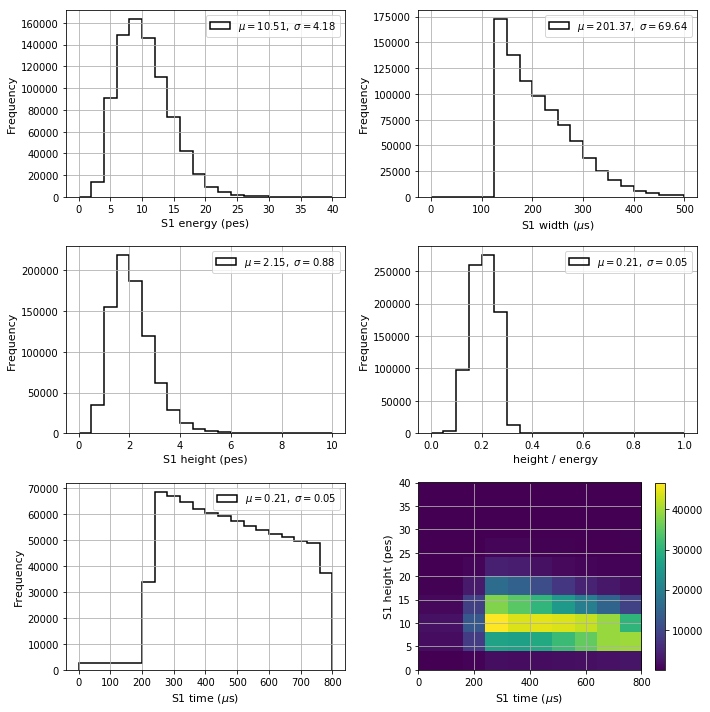

In [18]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))
plt.savefig(summary_outputs+'s1.png')
print('Plot saved to', summary_outputs+'s1.png')

### nS2 selection (3rd chech)

In [19]:
nS2_eff_interval = (config_values.nS2_eff_min, config_values.nS2_eff_max+0.01)
with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
    mask_s2 = selection_nS_mask_and_checking(dst        = dst               ,
                                             column     = type_of_signal.nS2,
                                             interval   = nS2_eff_interval  ,
                                             output_f   = store_hist        ,
                                             input_mask = mask_s1           ,
                                             nbins_hist = 10                ,
                                             range_hist = (0,10)            ,
                                             norm       = True              )

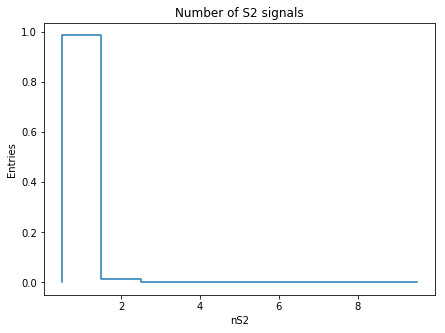

In [20]:
s2_hist = pd.read_hdf(histo_file_out, key='nS2')
plt.figure(figsize=(7,5));
plt.step(s2_hist.magnitude, s2_hist.entries, where='pre');
plt.xlabel('nS2');
plt.ylabel('Entries');
plt.title('Number of S2 signals');

In [21]:
eff = dst[mask_s2].event.nunique()/dst[mask_s1].event.nunique()
print('S2 selection efficiency: ', eff*100, '%')
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'fracS2={round(eff,2)}\n')
summary_vals.close()

S2 selection efficiency:  99.01735273226743 %


In [22]:
vals_loc

'/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_8070st200819/vals_8070.txt'

In [23]:
eff = dst[mask_s2].event.nunique()/dst.event.nunique()
print('Overall selection efficiency: ', eff*100, '%')
summary_vals = open(vals_loc, 'a')
summary_vals.write(f'fracS1S2={round(eff,2)}\n')
summary_vals.close()

Overall selection efficiency:  87.66717846344355 %


*Some other S2 plots:*

Figure saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/s2.png


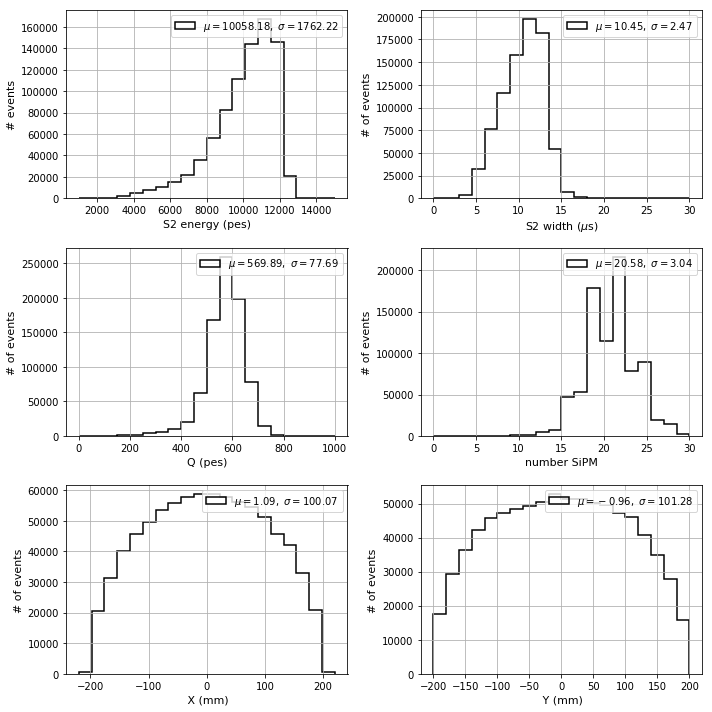

In [24]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))
plt.savefig(summary_outputs+'s2.png')
print('Figure saved to', summary_outputs+'s2.png')

### 4th check: Z distribution of events is correct

In [25]:
check_Z_dst(Z_vect   = dst[mask_s2].Z            ,
            ref_hist = ref_histos.Z_dist_hist    ,
            n_sigmas = config_values.nsigmas_Zdst)

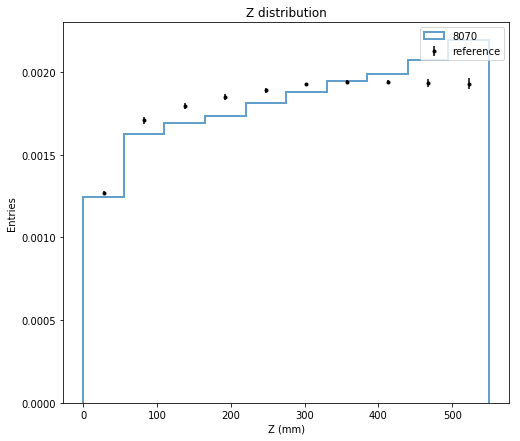

In [26]:
plt.figure(figsize=(8,7));
plt.title('Z distribution');
plt.hist(dst[mask_s2].Z, 10, (0, 550), density=1, histtype='step', alpha=0.7, linewidth=2, label=[run_number]);
plt.errorbar(ref_histos.Z_dist_hist.bin_centres, ref_histos.Z_dist_hist.bin_entries, yerr=ref_histos.Z_dist_hist.err_bin_entries, fmt='.k', label='reference');
plt.legend();
plt.ylabel('Entries');
plt.xlabel('Z (mm)');

*And XY distribution:*

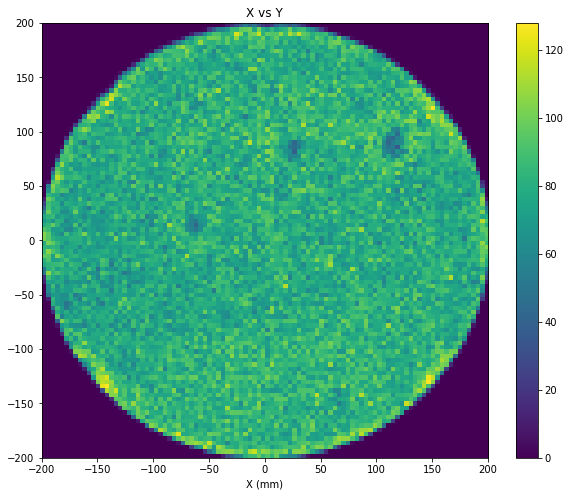

In [27]:
plt.figure(figsize=(10,8))
plt.hist2d(dst[mask_s2].X, dst[mask_s2].Y, 100, [(-200,200),(-200,200)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

### Time stamps

### Band selection (5th check)

*Geom. correction with bootstrap map is applied before*:

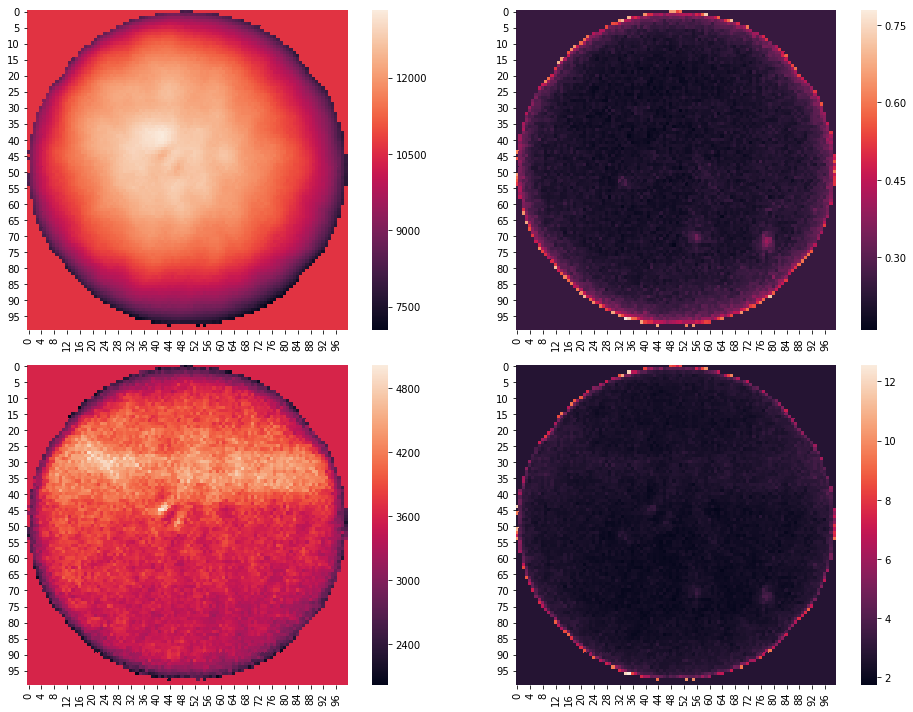

In [28]:
draw_xy_maps(bootstrapmap)

*Applying geometrical correction:*

In [29]:
geom_corr = e0_xy_correction(bootstrapmap)
corr = geom_corr(dst[mask_s2].X, dst[mask_s2].Y)

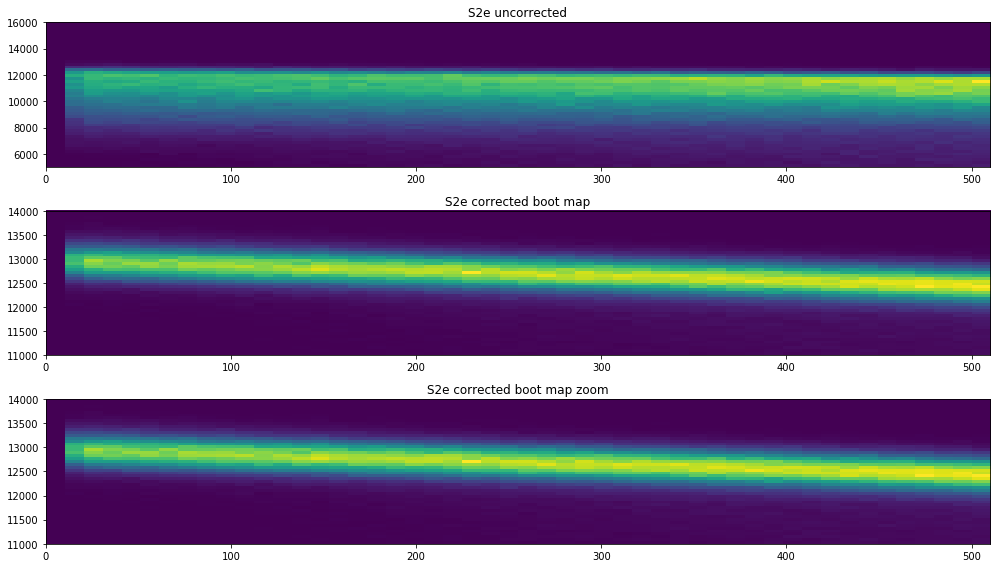

In [30]:
fig = plt.figure(figsize=(14,8))
plt.subplot(3, 1, 1)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, range=[[0,510],[5000, 16000]]);

plt.title('S2e uncorrected')
plt.subplot(3, 1, 2)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,510],[11000, 14000]])
plt.title('S2e corrected boot map')

plt.subplot(3, 1, 3)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,510],[11000, 14000]])
plt.title('S2e corrected boot map zoom')
plt.tight_layout()

*Selection:*

In [31]:
config['band_sel_params']

{'range_Z': (10, 550),
 'range_E': (10000.0, 14000.0),
 'nbins_z': 50,
 'nbins_e': 50,
 'nsigma_sel': 3.5,
 'eff_min': 0.0,
 'eff_max': 1.0}

In [32]:
band_sel_params_new = config['band_sel_params']
band_sel_params_new['range_Z'] = (5, 510)
band_sel_params_new['range_E'] = (11000, 14000)
#band_sel_params_new['range_Z'] = (10, 510)
band_sel_params_new['nsigma_sel'] = 3.5
#config.update(dict(map_params = map_params_new))

In [33]:
band_sel_params_new

{'range_Z': (5, 510),
 'range_E': (11000, 14000),
 'nbins_z': 50,
 'nbins_e': 50,
 'nsigma_sel': 3.5,
 'eff_min': 0.0,
 'eff_max': 1.0}

In [34]:
band_sel_params = config_values.band_sel_params
mask_band = band_selector_and_check(dst        = dst         ,
                                    boot_map   = bootstrapmap,
                                    input_mask = mask_s2     ,
                                    **band_sel_params_new    )

In [35]:
eff = dst[mask_band].event.nunique()/dst[mask_s2].event.nunique()
print('Band selection efficiency: ', eff*100, '%')

Band selection efficiency:  91.86967537608868 %


In [36]:
emaps = e0_xy_correction(bootstrapmap)
E0 = dst[mask_s2].S2e.values * emaps(dst[mask_s2].X.values, dst[mask_s2].Y.values)

sel_krband = np.zeros_like(mask_s2)
sel_krband[mask_s2], fpl, fph, hp, pp = selection_in_band(dst[mask_s2].Z,
                                                          E0,
                                                          range_z = band_sel_params_new['range_Z'],
                                                          range_e = band_sel_params_new['range_E'],
                                                          nbins_z = band_sel_params_new['nbins_z'],
                                                          nbins_e = band_sel_params_new['nbins_e'],
                                                          nsigma  = band_sel_params_new['nsigma_sel'])

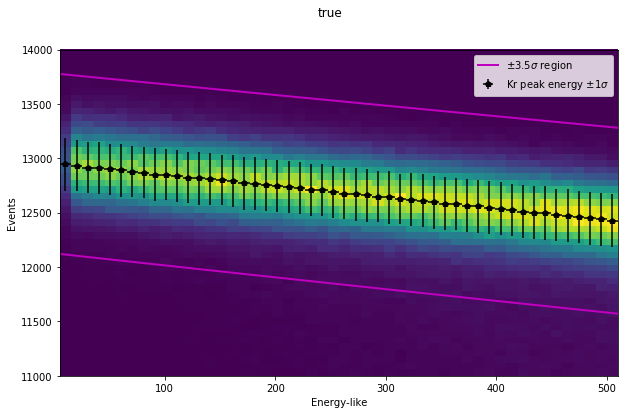

In [37]:
plot_selection_in_band(fpl, fph, hp, pp, nsigma = band_sel_params_new['nsigma_sel'])

*Krypton peak after geometrical correction:*

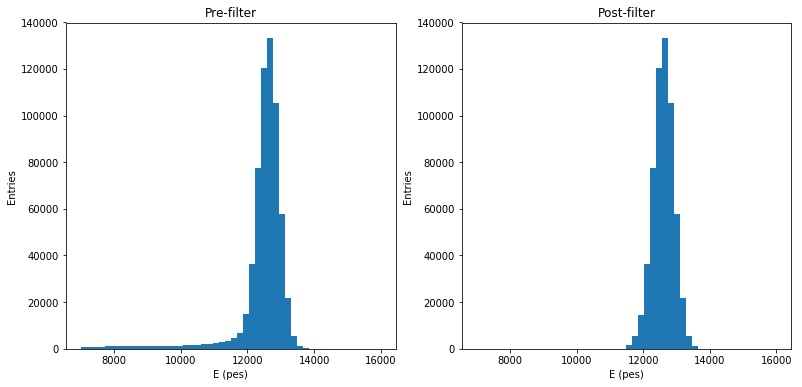

In [38]:
corr_band = geom_corr(dst[mask_band].X, dst[mask_band].Y)
fig = plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.hist(dst[mask_s2].S2e*corr,  bins = 50, range =(7000, 16000))
plt.title('Pre-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.subplot(1, 2, 2)
plt.hist(dst[mask_band].S2e*corr_band,  bins = 50, range =(7000, 16000))
plt.title('Post-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');

In [39]:
sel_dst = dst[mask_band]

Figure saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/EventDist_8070.png


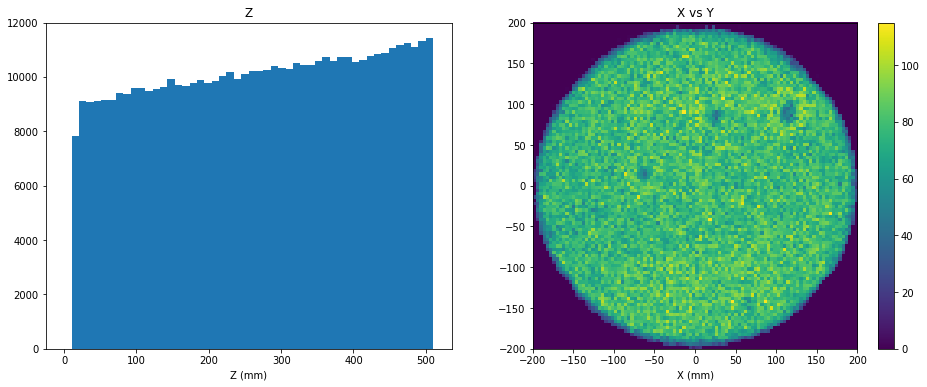

In [40]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(sel_dst.Z, bins = 50, range =(0,510))
plt.title('Z')
plt.xlabel('Z (mm)');
plt.subplot(1,2,2);
plt.hist2d(sel_dst.X, sel_dst.Y, 100, [(-200,200),(-200,200)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();
plt.savefig(summary_outputs+'EventDist_'+str(run_number)+'.png')
print('Figure saved to', summary_outputs+'EventDist_'+str(run_number)+'.png')

If all selection cuts and checks are passed successfully, it is time to create the correction map.

## Map production

#### Selection of number of XY bins

In [41]:
thr_evts_for_sel_map_bins = config_values.thr_evts_for_sel_map_bins
default_n_bins            = config_values.default_n_bins

- If the number of evts is greater than 1e6 -> 100x100 map
- If the number of evts is lower than 1e6 -> 50x50 map

In [42]:
number_of_bins = get_binning_auto(nevt_sel                = sel_dst.event.nunique()  ,
                                  thr_events_for_map_bins = thr_evts_for_sel_map_bins,
                                  n_bins                  = default_n_bins           )
print('Number of XY bins: ', number_of_bins, '(', sel_dst.event.nunique(), 'events)')

Number of XY bins:  50 ( 580157 events)


### Map computation

In [43]:
map_params = config_values.map_params

In [44]:
map_params

{'nbins_z': 15,
 'nbins_e': 25,
 'z_range': (10, 550),
 'e_range': (2000, 18000),
 'chi2_range': (0, 10),
 'lt_range': (1000, 15000),
 'nmin': 100,
 'maxFailed': 600,
 'r_max': 200,
 'r_fid': 100,
 'nStimeprofile': 1800,
 'x_range': (-200, 200),
 'y_range': (-200, 200)}

In [45]:
map_params_new = config['map_params']
map_params_new['nbins_z']   = (15)
map_params_new['z_range']   = (10, 510)
map_params_new['e_range']    = (10000, 16000)
map_params_new['lt_range']   = (5000, 20000)
map_params_new['chi2_range'] = (0, 5)
map_params_new['r_max'] = 200
map_params_new['x_range'] = (-200, 200)
map_params_new['y_range'] = (-200, 200)
map_params_new['maxFailed'] = 2500

In [46]:
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [47]:
maps = calculate_map(dst        = sel_dst                 ,
                     XYbins     = (number_of_bins         ,
                                   number_of_bins)        ,
                     nbins_z    = map_params_new['nbins_z']   ,
                     nbins_e    = map_params_new['nbins_e']   ,
                     z_range    = map_params_new['z_range']   ,
                     e_range    = map_params_new['e_range']   ,
                     chi2_range = map_params_new['chi2_range'],
                     lt_range   = map_params_new['lt_range']  ,
                     fit_type   = FitType.unbined         ,
                     nmin       = map_params_new['nmin']      ,
                     x_range    = map_params_new['x_range']   ,
                     y_range    = map_params_new['y_range']   )

### Last check: number of failed fits

In [48]:
maxFailed = map_params['maxFailed']
r_max     = map_params['r_max']

check_failed_fits(maps      = maps          ,
                  maxFailed = maxFailed     ,
                  nbins     = number_of_bins,
                  rmax      = r_max         ,
                  rfid      = r_max         )

    Number of failing fits: 149


#### chi2 regularization and compute relative error maps, instead of absolute error.

In [49]:
regularized_maps = regularize_map(maps    = maps                    ,
                                  x2range = map_params['chi2_range'])

regularized_maps = relative_errors(am = regularized_maps)

Now, the outer bins are replaced by nans:

In [50]:
regularized_maps = remove_peripheral(map   = regularized_maps,
                                     nbins = number_of_bins  ,
                                     rmax  = r_max           ,
                                     rfid  = r_max           )

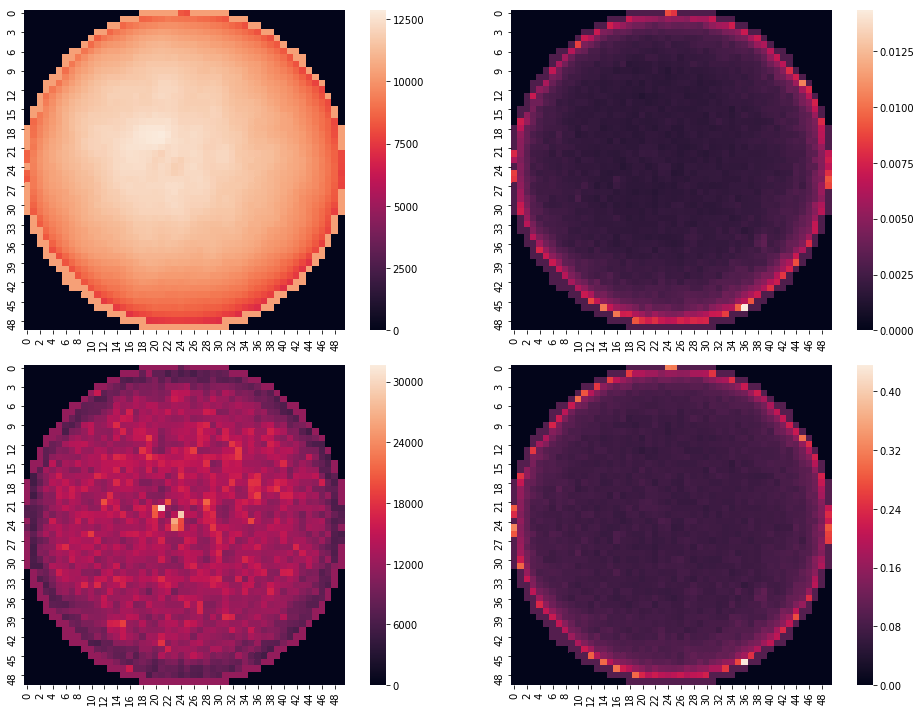

In [51]:
draw_xy_maps(regularized_maps,
             figsize=(14,10))

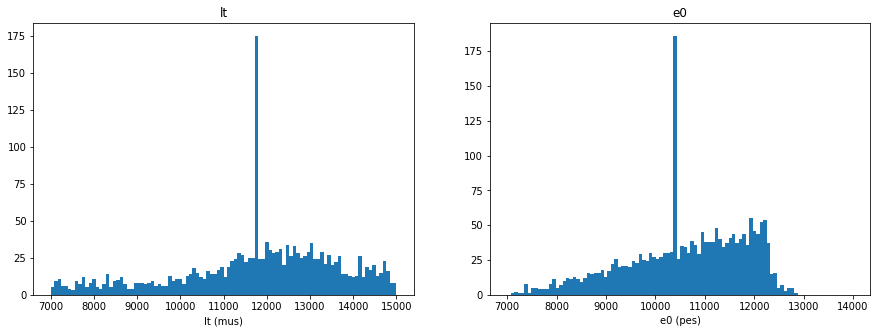

In [52]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(regularized_maps.lt.values.flatten(), 100, (7000, 15000));
plt.title('lt')
plt.xlabel('lt (mus)');
plt.subplot(122)
plt.hist(regularized_maps.e0.values.flatten(), 100, (7000, 14000));
plt.title('e0')
plt.xlabel('e0 (pes)');

#### Mapinfo table is added

In [53]:
maps = add_mapinfo(asm        = regularized_maps     ,
                   xr         = map_params['x_range'],
                   yr         = map_params['y_range'],
                   nx         = number_of_bins       ,
                   ny         = number_of_bins       ,
                   run_number = run_number           )
print(maps.mapinfo)

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    8070
dtype: int64


#### Temporal evolution table is added

In [54]:
#r_fid         = map_params['r_fid']
#nStimeprofile = map_params['nStimeprofile']
#add_krevol(maps          = maps                 ,
#           dst           = sel_dst              ,
#           r_fid         = r_fid                ,
#           nStimeprofile = nStimeprofile        ,
#           x_range       = map_params['x_range'],
#           y_range       = map_params['y_range'],
#           XYbins        = (number_of_bins      ,
#                            number_of_bins     ))
#temp = maps.t_evol

In [55]:
#plt.figure(figsize=(16, 20));
#plt.subplot(3,2,1);
#plt.title('e0');
#plt.errorbar(temp.ts, temp.e0, temp.e0u, fmt='.', linestyle='-');
#plt.subplot(3,2,2);
#plt.title('lt');
#plt.errorbar(temp.ts, temp['lt'], temp['ltu'], fmt='.', linestyle='-');
#plt.subplot(3,2,3);
#plt.title('dv');
#plt.ylim(0.907, 0.920);
#plt.errorbar(temp.ts, temp.dv, temp.dvu, fmt='.', linestyle='-');
#plt.subplot(3,2,4);
#plt.title('s1e');
#plt.errorbar(temp.ts, temp.s1e, temp.s1eu, fmt='.', linestyle='-');
#plt.subplot(3,2,5);
#plt.title('s2e');
#plt.errorbar(temp.ts, temp.s2e, temp.s2eu, fmt='.', linestyle='-');
#plt.subplot(3,2,6);
#plt.title('Nsipm');
#plt.errorbar(temp.ts, temp.Nsipm, temp.Nsipmu, fmt='.', linestyle='-');

### Writing final map

In [56]:
write_complete_maps(asm      = maps        ,
                    filename = map_file_out)

*****

# Section C: Checking map <a id='SectionC'></a>


In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from invisible_cities.reco.corrections       import read_maps
from invisible_cities.reco.corrections       import apply_all_correction
from krcal.NB_utils  .xy_maps_functions      import draw_xy_maps

from krcal.NB_utils.plt_functions             import h1, h2
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy
from krcal.NB_utils.plt_energy_functions      import resolution_r_z, plot_resolution_r_z

from krcal.map_builder.map_builder_functions  import e0_xy_correction
from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import apply_cuts
from krcal.map_builder.map_builder_functions  import type_of_signal

### Opening map

In [58]:
try:
    final_map = read_maps(map_file_out)
except FileNotFoundError:
    print('Please run Section A or B. If you have already done it, the dst is not good enough to produce a map :(')

In [59]:
from krcal.core. kr_types        import ASectorMap
from typing            import Optional
from matplotlib.colors import Colormap
import seaborn as sns
from typing                 import Tuple

def draw_xy_maps_mod(aMap    : ASectorMap,
                 e0lims   : Optional[Tuple[float, float]] = None,
                 ltlims   : Optional[Tuple[float, float]] = None,
                 eulims   : Optional[Tuple[float, float]] = None,
                 lulims   : Optional[Tuple[float, float]] = None,
                 cmap    :  Optional[Colormap]            = None,
                 figsize : Tuple[float, float]            = (14,10)):
    """
    draws correction maps (e0, lt, e0u, ltu) in bins of xy.
    Parameters
    ----------
    aMap
        A container of maps.
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame
    e0lims
        Defines the range of e0 in pes (e.g, (8000,14000)).
    ltlims
        Defines the range of lt in mus (e.g, (3000,5000)).
    eulims
        Defines the range of e0u in pes (or relative).
    lulims
        Defines the range of ltu in mus (or relative).
    cmap
        color map. For example: cmap = matplotlib.cm.viridis (defaults to seaborn)
    figsize
        Range definint the figure size.
    Returns
    -------
    Nothing
        Function produces a plot.
    """
    def vmin_max(lims):
        if lims == None:
            vmin = None
            vmax = None
        else:
            vmin=lims[0]
            vmax=lims[1]
        return vmin, vmax

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(2,2,1)
    vmin, vmax = vmin_max(e0lims)
    sns.heatmap(aMap.e0.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,2)
    vmin, vmax = vmin_max(eulims)
    sns.heatmap(aMap.e0u.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,3)
    vmin, vmax = vmin_max(ltlims)
    sns.heatmap(aMap.lt.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,4)
    vmin, vmax = vmin_max(lulims)
    sns.heatmap(aMap.ltu.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)
    plt.tight_layout()

Saved plot to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/lt_e0_xy_8070.png


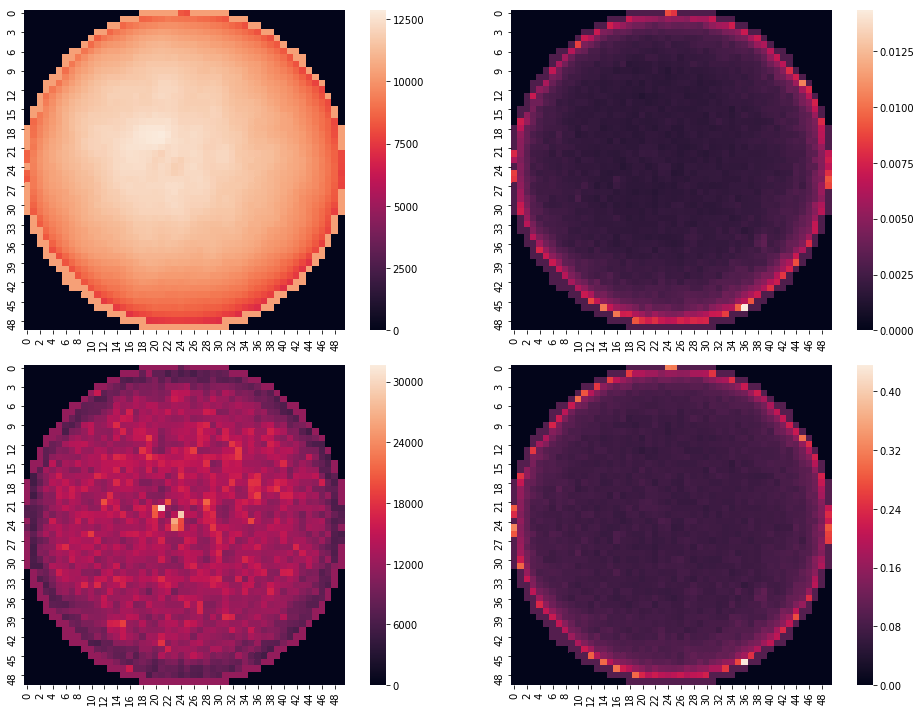

In [60]:
draw_xy_maps_mod(final_map,
             figsize=(14,10))
plt.savefig(summary_outputs+'lt_e0_xy_'+str(run_number)+'.png')
print('Saved plot to', summary_outputs+'lt_e0_xy_'+str(run_number)+'.png')

In [61]:
final_map.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    8070
dtype: int64

### Opening and selecting dst (only if section B is not run)

In [62]:
try :
    sel_dst;
except NameError:
    config_values = config.as_namespace
    
    inputs = load_data(input_path         = folder_dst                  ,
                       input_dsts         = dst_file                    ,
                       file_bootstrap_map = file_bootstrap              ,
                       quality_ranges     = config_values.quality_ranges,
                       **config_values.ref_Z_histogram                  )

    dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]
    
    with pd.HDFStore(histo_file_out, "r+", complib=str("zlib"), complevel=4) as store_hist:
        sel_dst = apply_cuts(dst              = dst                           ,
                             S1_signal        = type_of_signal.nS1            ,
                             nS1_eff_interval = (config_values.nS1_eff_min    ,
                                                 config_values.nS1_eff_max)   ,
                             store_hist_s1    = store_hist                    ,
                             ns1_histo_params = config_values.ns1_histo_params,
                             S2_signal        = type_of_signal.nS2            ,
                             nS2_eff_interval = (config_values.nS2_eff_min    ,
                                                 config_values.nS2_eff_max)   ,
                             store_hist_s2    = store_hist                    ,
                             ns2_histo_params = config_values.ns2_histo_params,
                             nsigmas_Zdst     = config_values.nsigmas_Zdst    ,
                             ref_Z_histo      = ref_histos.
                                                    Z_dist_hist               ,
                             bootstrapmap     = bootstrapmap                  ,
                             band_sel_params  = config_values.band_sel_params )

### Applying corrections to the selected dst

In [63]:
sel_dst = sel_dst[sel_dst.R<200]

In [64]:
geom_corr = e0_xy_correction(final_map)
total_correction = apply_all_correction(final_map, apply_temp=False)

corr_geo = geom_corr(sel_dst.X, sel_dst.Y)
corr_tot = total_correction(sel_dst.X, sel_dst.Y, sel_dst.Z, sel_dst.time)

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/CorrectionLT.png


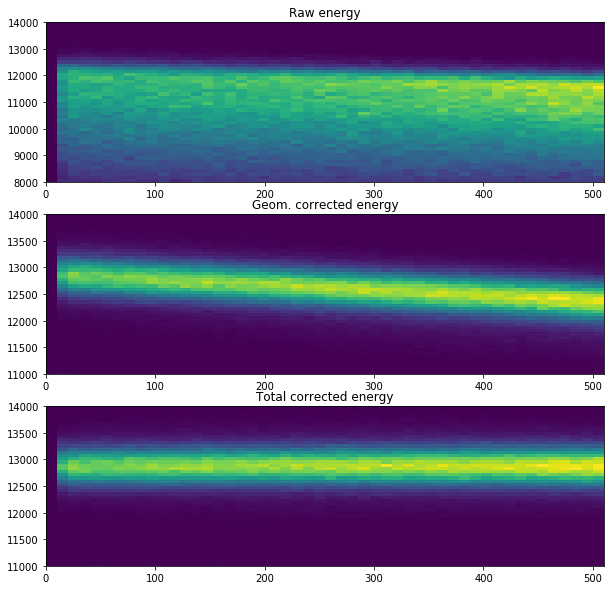

In [65]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, [(0,510),(8000,14000)])
plt.title('Raw energy');
plt.subplot(3, 1, 2)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_geo, 50, [(0,510),(11000,14000)])
plt.title('Geom. corrected energy');
plt.subplot(3, 1, 3)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_tot, 50, [(0,510),(11000,14000)])
plt.title('Total corrected energy');
plt.savefig(summary_outputs+'CorrectionLT.png')
print('Plot saved to', summary_outputs+'CorrectionLT.png')

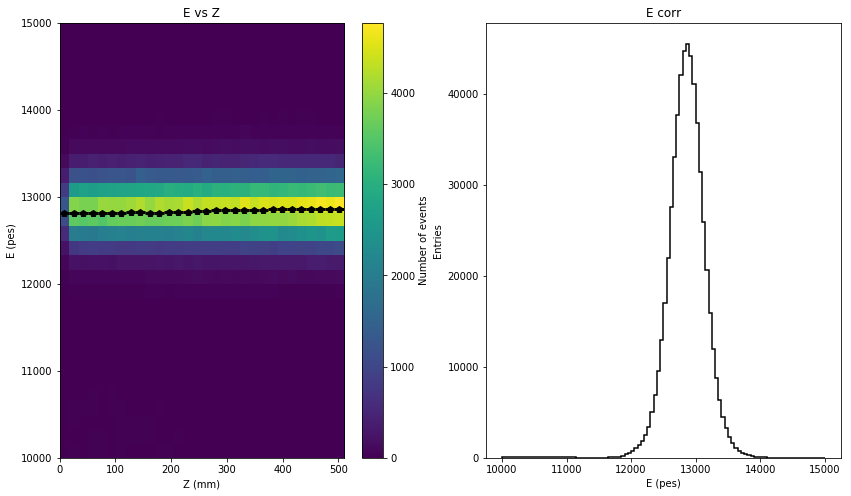

In [66]:
e_range = (10000,15000)
zrange = (0,510)
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

nevt = h2(sel_dst.Z, sel_dst.S2e*corr_tot, 30, 30, zrange, e_range, profile=True)
plt.xlabel('Z (mm)');
plt.ylabel('E (pes)');
plt.title('E vs Z');

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(sel_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.title('E corr');

  Fit was valid = True
 Emu       = 12868.176424866178 +-0.3492912580013655 
 E sigma   = 260.8995554927813 +-0.27240777078624173 
 chi2    = 68.17883441761109 
 sigma E/E (FWHM)     (%) =4.76457529928847
 sigma E/E (FWHM) Qbb (%) =0.615354221051766 


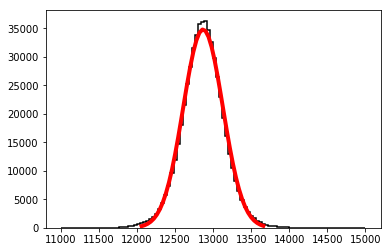

In [67]:
fc = fit_energy(sel_dst.S2e*corr_tot, nbins=100, range=(11000, 15000))
plot_fit_energy(fc)
print_fit_energy(fc)

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/ResoFit.png


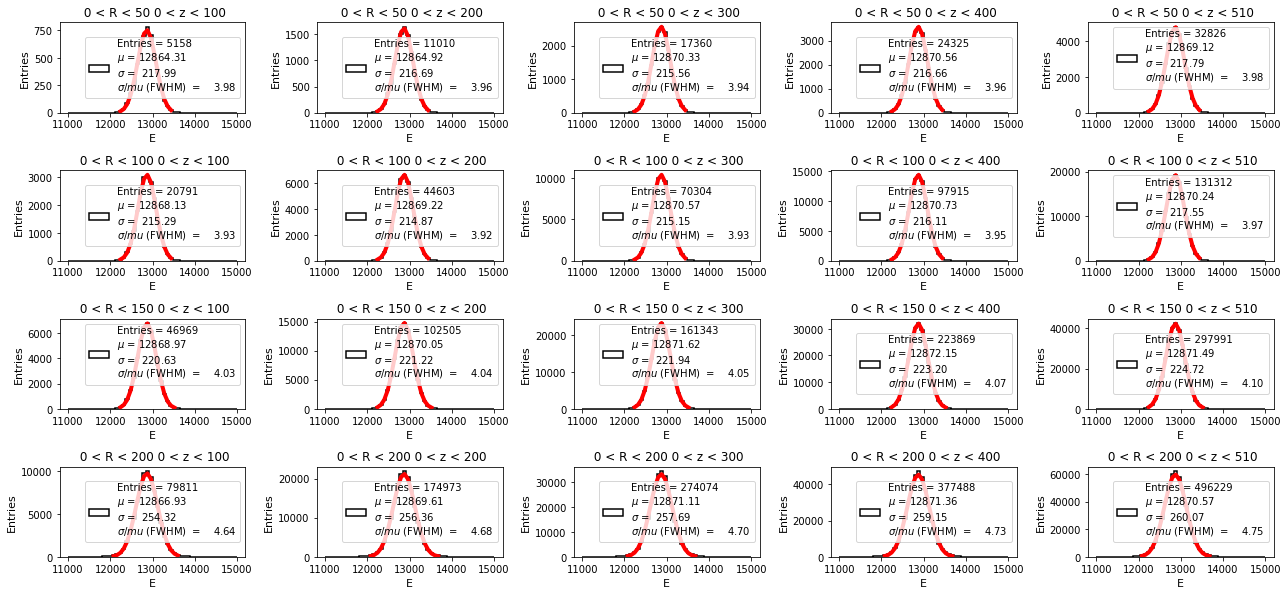

In [68]:
Ri = (50,100,150, 200)
Zi = (100, 200, 300, 400, 510)

FC, FCE = resolution_r_z(Ri, Zi, sel_dst.R, sel_dst.Z, sel_dst.S2e*corr_tot,
                    enbins = 50,
                    erange = (11000,15000),
                    ixy = (5,5),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))

plt.savefig(summary_outputs+'ResoFit.png')
print('Plot saved to', summary_outputs+'ResoFit.png')

In [69]:
from typing      import Iterable
from pandas      import DataFrame

def plot_resolution_r_z_mod(Ri : Iterable[float],
                        Zi : Iterable[float],
                        FC : DataFrame,
                        FCE : DataFrame,
                        r_range: Tuple[float,float] = (3.5, 4.5),
                        figsize = (14,10)):

    def extrapolate_to_qbb(es : float)->float:
        return np.sqrt(41 / 2458) * es

    def np_extrapolate_to_qbb(es : np.array)->np.array:
        return np.sqrt(41 / 2458) * es

    TEXTSIZE = 20
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)


    fig       = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    Zcenters =np.array(list(Zi))
    for i in FC.columns:
        label = f'0 < R < {Ri[i]:2.0f}'

        es = FC[i].values
        eus = FCE[i].values
        qes = extrapolate_to_qbb(es)
        qeus = extrapolate_to_qbb(eus)
        ax.errorbar(Zcenters, es, eus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
        ax2.errorbar(Zcenters, qes, qeus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
    plt.grid(True)
    ax.set_ylim(r_range)
    ax2.set_ylim(np_extrapolate_to_qbb(np.array(r_range)))

    ax.set_xlabel(' z (mm)')
    ax.set_ylabel('resolution FWHM (%)')
    ax2.set_ylabel('resolution Qbb FWHM (%)')

    plt.legend()



Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/ResoVsZR.png


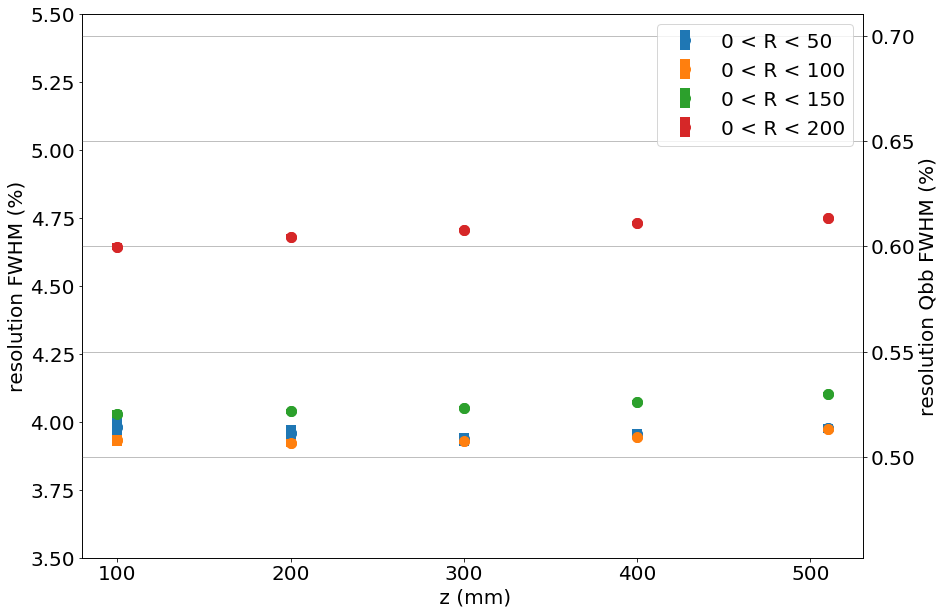

In [70]:
plot_resolution_r_z_mod(Ri, Zi, FC, FCE, r_range=(3.5,5.5))
plt.savefig(summary_outputs+'ResoVsZR.png')
print('Plot saved to', summary_outputs+'ResoVsZR.png')

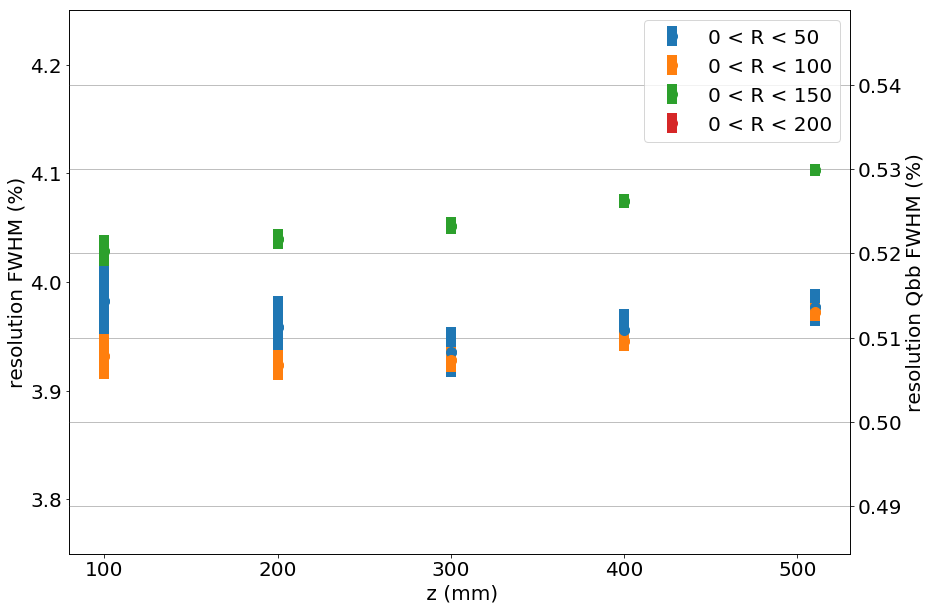

In [71]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(3.75,4.25))

## Time dependence of detector parameters

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/AverageLT.png


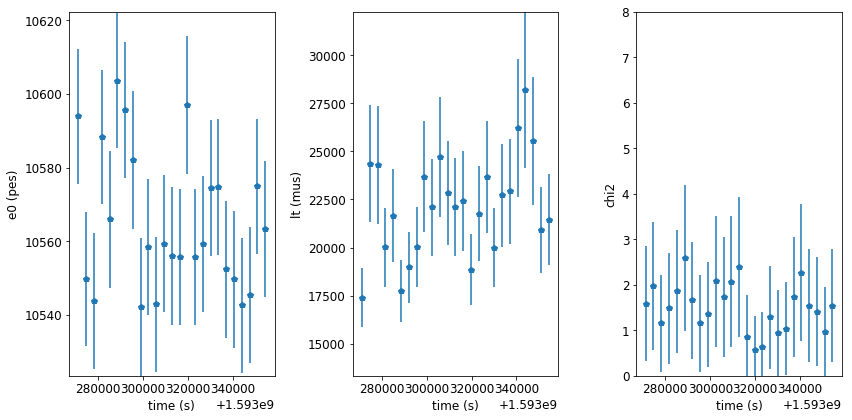

In [72]:
dst_time = sel_dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
time_bins = 25

ts, masks = get_time_series_df(time_bins, (T[0],T[-1]), sel_dst)

TEXTSIZE = 12
plt.rc('font', size=TEXTSIZE)
plt.rc('axes', titlesize=TEXTSIZE)
plt.rc('axes', labelsize=TEXTSIZE)
plt.rc('xtick', labelsize=TEXTSIZE)
plt.rc('ytick', labelsize=TEXTSIZE)
plt.rc('legend', fontsize=TEXTSIZE)
plt.rc('figure', titlesize=TEXTSIZE)

fps = time_fcs_df(ts, masks, sel_dst, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

plot_time_fcs(fps,
              range_chi2  = (0,8),
              range_e0    = (min(fps.e0)-max(fps.e0u), max(fps.e0)+max(fps.e0u)),
              range_lt    = (min(fps.lt)-max(fps.ltu), max(fps.lt)+max(fps.ltu)),
              figsize     = (12,6))

plt.savefig(summary_outputs+'AverageLT.png')
print('Plot saved to', summary_outputs+'AverageLT.png')

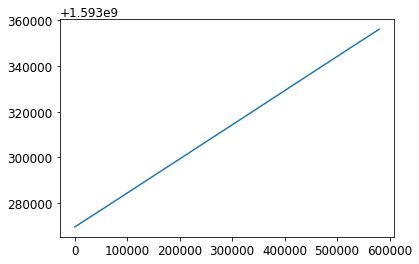

In [73]:
plt.plot(T)
plt.savefig(summary_outputs+'runTime.png')

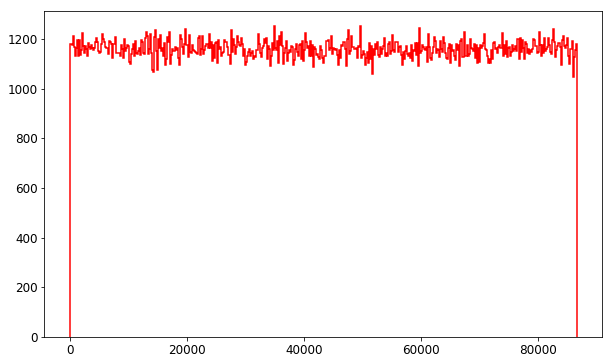

In [74]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(DT, bins=500, range = (DT[0], DT[-1]), color='red', stats=False, lbl='post-sel')
plt.savefig(summary_outputs+'runEvt.png')

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/RProfile.png


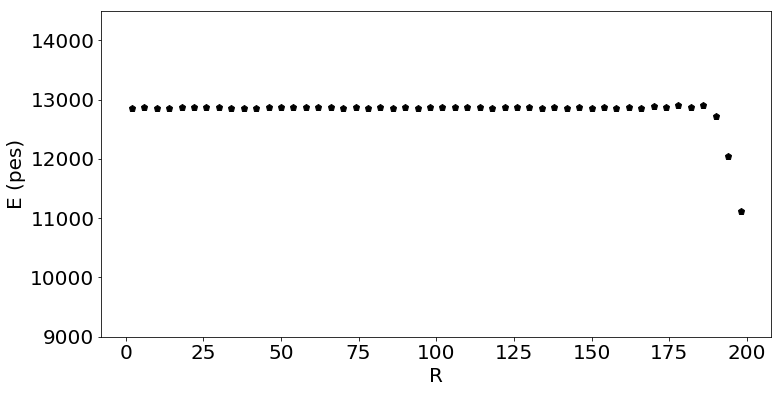

In [75]:
import invisible_cities.core.fit_functions as fitf

def energy_X_profile(X      : np.array,
                     E      : np.array,
                     xnbins : int,
                     xrange : Tuple[float, float],
                     xlabel : str = 'R',
                     erange : Tuple[float, float] = (9e+3, 14e+3),
                     figsize : Tuple[float, float] = (10,8)):

    TEXTSIZE = 20
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)

    fig = plt.figure(figsize=figsize)

    x, y, yu = fitf.profileX(X, E, xnbins, xrange)
    ax = fig.add_subplot(1, 1, 1)

    plt.errorbar(x, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel(xlabel)
    plt.ylabel('E (pes)')
    plt.ylim(erange)


    
num_xy_bins = 50
energy_X_profile(sel_dst.R, sel_dst.S2e*corr_tot, xnbins = number_of_bins, xrange=(0,200), xlabel = 'R',
                 erange=(9000, 14500),  
                 figsize=(12,6))


plt.savefig(summary_outputs+'RProfile.png')
print('Plot saved to', summary_outputs+'RProfile.png')

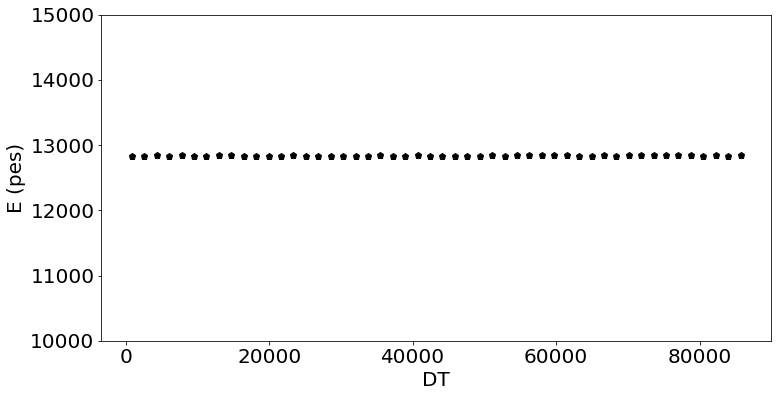

In [76]:
energy_X_profile(DT, sel_dst.S2e*corr_tot, xnbins = number_of_bins, xrange=(DT[0], DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'TProfile.png')

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/ZProfile.png


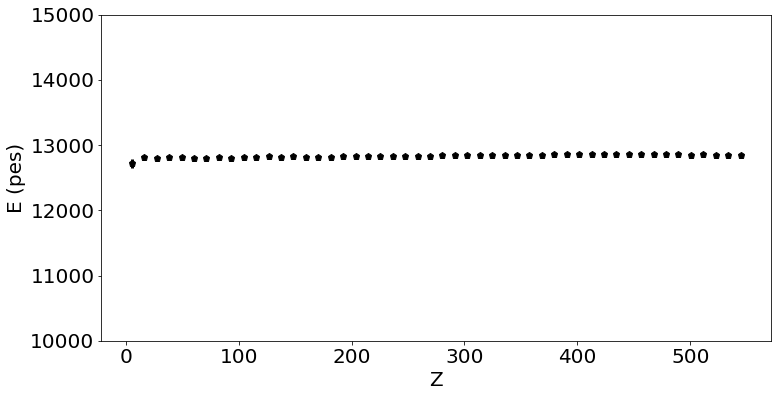

In [77]:
energy_X_profile(sel_dst.Z, sel_dst.S2e*corr_tot, xnbins = number_of_bins, xrange=(0, 550), xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'ZProfile.png')
print('Plot saved to', summary_outputs+'ZProfile.png')

In [78]:
plot_output_dir = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
plot_outputs = open(plot_output_dir+'plot_outputs_'+str(run_number)+analysis_tag+'.txt','w+')

def to_output(mylist, name):
    return name+':'+str(list(mylist))+'\n'

In [79]:
plot_outputs.write(to_output(Ri, 'Ri'))
plot_outputs.write(to_output(Zi, 'Zi'))
plot_outputs.write(to_output(FC.values.T.tolist(), 'FC'))
plot_outputs.write(to_output(FCE.values.T.tolist(), 'FCE'))

plot_outputs.write(to_output(fps.ts, 'fps.ts'))
plot_outputs.write(to_output(fps.e0, 'fps.e0'))
plot_outputs.write(to_output(fps.e0u, 'fps.e0u'))
plot_outputs.write(to_output(fps.lt, 'fps.lt'))
plot_outputs.write(to_output(fps.ltu, 'fps.ltu'))
plot_outputs.write(to_output(fps.c2, 'fps.c2'))

plot_outputs.close()

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/EffVsTime.png


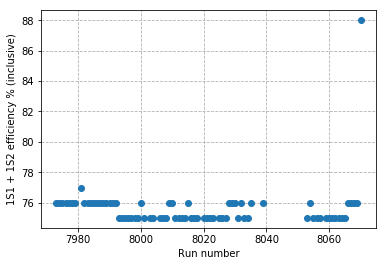

In [80]:
all_fracs = []
all_runs = []

run_min = run_number - 100
run_max = run_number + 1

old_tag = 'st190819'

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run)+analysis_tag+'/'
    full_path = outer_path +'vals_'+str(run)+'.txt'
    old_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run)+old_tag+'/'+'vals_'+str(run)+'.txt'

    if not os.path.exists(full_path):
        full_path = old_path
    
    try:

        test_file = open(full_path, "r")
        # print(full_path)
        for line in test_file:
            if not line.find('fracS1S2') == -1:
                fracS1S2 = 100 * float(line[9:])
                # print('Frac S1 + S2 = ' + str(fracS1S2))
                all_runs.append(run)
                all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')
plt.plot(all_runs, all_fracs, 'o')
plt.ylabel('1S1 + 1S2 efficiency % (inclusive)')
plt.xlabel('Run number')

plt.savefig(summary_outputs+'EffVsTime.png')
print('Plot saved to '+summary_outputs+'EffVsTime.png')

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/E0VsTime.png


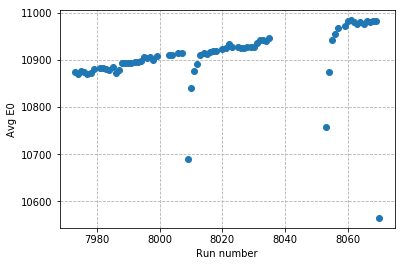

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/LTVsTime.png


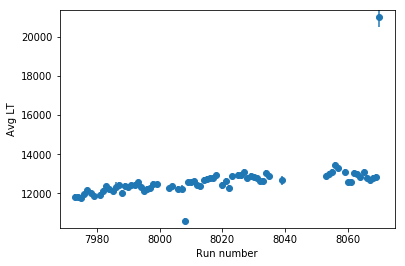

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r8070_st200819/ResVsTime.png


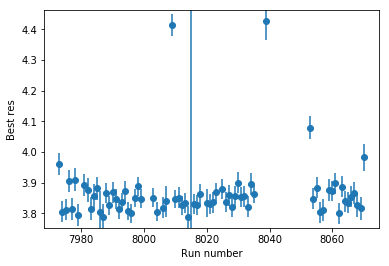

In [81]:
all_runs = []
all_e0s = []
all_lts = []
all_res = []
all_e0us = []
all_ltus = []
all_resus = []

# error = sqrt(1/sum(1/sigma_i^2))

old_tag = 'st190819'

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
    full_path = outer_path + 'plot_outputs_'+str(run)+analysis_tag+'.txt'
    old_path = outer_path + 'plot_outputs_'+str(run)+old_tag+'.txt'
    
    if not os.path.exists(full_path):
        full_path = old_path
    
    try:
        test_file = open(full_path, "r")
        for line in test_file:
            
            # Get the values
            if line.find('fps.e0:') != -1:
                run_e0s = np.array(eval(line[7:]))
            if line.find('fps.lt:') != -1:
                run_lts = np.array(eval(line[7:]))
            if line.find('FC:') != -1:
                run_res = eval(line[3:])[0][0]
            if line.find('FCE:') != -1:
                run_resu = eval(line[4:])[0][0]

            # Get the errors
            if line.find('fps.e0u:') != -1:
                run_e0us = np.array(eval(line[8:]))
            if line.find('fps.ltu:') != -1:
                run_ltus = np.array(eval(line[8:]))
        
        # Combine values over time into single value
        ltu_full = np.sqrt(1/np.sum(1/run_ltus**2))
        e0u_full = np.sqrt(1/np.sum(1/run_e0us**2))
        lt_weights = (ltu_full / run_ltus)**2
        e0_weights = (e0u_full / run_e0us)**2
        
        # Append values
        all_runs.append(run)
        all_e0s.append(np.average(run_e0s, weights = e0_weights))
        all_e0us.append(e0u_full)
        all_lts.append(np.average(run_lts, weights = lt_weights))
        all_ltus.append(ltu_full)
        all_res.append(run_res)
        all_resus.append(run_resu)
            
        # fracS1S2 = 100 * float(line[9:])
        # print('Frac S1 + S2 = ' + str(fracS1S2))
        # all_runs_s1s2.append(run)
        # all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')

def get_ylim(myData):
    data = np.array(myData)
    mean = np.mean(data)
    stdev = np.std(data)
    
    # Cut out everything that isn't within 3 stdevs, except the most recent point
    upper = max(mean + 2.5 * stdev, data[-1])
    lower = min(mean - 2.5 * stdev, data[-1])
    good_data = data[data <= upper]
    good_data = good_data[good_data >= lower]
    
    # Reset the bounds to include the good data only
    lower = np.min(good_data) - np.std(good_data)/3
    upper = np.max(good_data) + np.std(good_data)/3
    
    return (lower, upper)

plt.errorbar(all_runs, all_e0s, yerr = all_e0us, fmt='o')
plt.ylabel('Avg E0')
plt.xlabel('Run number')
plt.ylim(get_ylim(all_e0s))
plt.savefig(summary_outputs+'E0VsTime.png')
print('Plot saved to '+summary_outputs+'E0VsTime.png')
plt.show()

plt.errorbar(all_runs, all_lts, yerr = all_ltus, fmt='o')
plt.ylabel('Avg LT')
plt.xlabel('Run number')
plt.ylim(get_ylim(all_lts))
plt.savefig(summary_outputs+'LTVsTime.png')
print('Plot saved to '+summary_outputs+'LTVsTime.png')
plt.show()

plt.errorbar(all_runs, all_res, yerr = all_resus, fmt='o')
plt.ylabel('Best res')
plt.xlabel('Run number')
plt.ylim(get_ylim(all_res))
plt.savefig(summary_outputs+'ResVsTime.png')
print('Plot saved to '+summary_outputs+'ResVsTime.png')
plt.show()

In [82]:
def ndigit(a, n):
    a = str(a)
    if len(a) >= n:
        return a
    else:
        return '0'*(n - len(a))+a

In [83]:
from datetime import datetime

mydate = datetime.fromtimestamp(T[-1])
final_date = str(mydate.year)+'-'+ndigit(mydate.month,2)+'-'+ndigit(mydate.day,2)

import codecs

ctrl = 'SNS'

def itemize(line):
    items = []
    while len(line) > 0:
        if not line.find('\t') == -1:
            potential_item = line[:line.find('\t')]
            potential_item = potential_item.strip()
            if not potential_item == "":
                items.append(potential_item)
            line = line[line.find('\t')+1:]
        elif line.find('\n') == -1:
            items.append(line)
            line = ""
        else:
            line = ""
    return items

vessel_temps = []
param_of_interest = "NEW"

text_path = "/Users/jmhaefner/Dropbox/Data/" + ctrl + "_Data_Report_" + final_date + ".txt"

if os.path.isfile(text_path):
    data_file = codecs.open(text_path, 'r', encoding='ISO-8859-1')
    data_lines = data_file.readlines()

    parameters = itemize(data_lines[2])
    first_data = itemize(data_lines[3])

    for i in range(len(parameters)):
        try:
            print_params = parameters[i]+'='+first_data[i]
            #print(print_params)
        except:
            # print('Failed to find a value for param', [parameters[i]])
            parameters.pop(i)
            i -= 1

    for i in range(len(parameters)):
        for j in range(3,len(data_lines)):
            if parameters[i] == param_of_interest:
                itemized = itemize(data_lines[j])
                value = float(itemized[i].replace(',', '.'))
                vessel_temps.append(value)

    day_temp = sum(vessel_temps)/(1.0 * len(vessel_temps))
    print('The day temp on '+final_date+' was '+str(round(day_temp,1)))
else:
    day_temp = 'nan'
    print('UNABLE TO FIND TEMPERATURE FILE '+text_path)

summary_vals = open(vals_loc, 'a')
summary_vals.write('date='+final_date+'\n')
if day_temp != 'nan':
    summary_vals.write('labTempC='+str(round(day_temp,1))+'\n')
else:
    summary_vals.write('labTempC='+day_temp)
summary_vals.close()

The day temp on 2020-06-28 was 20.1
